In [1292]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import networkx as nx
import scipy.stats as stats
import math
import copy
#from kneed import KneeLocator
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [1478]:
globalNumber = 500
clusterNumber = 3
topKK = 50

# input cost vector to be visualzed
with open("../global_cost_vectors_500_lRand.pk",'rb') as f:
    global_cost = pickle.load(f)
with open("../global_trips_500_lRand.pk",'rb') as f:
    global_dict = pickle.load(f)
with open("trajectories_local_50_w07_near_adjusted_cost.pk",'rb') as f:
    local_cost = pickle.load(f)
with open("trajectories_local_50_w07_near_adjusted_route.pk",'rb') as f:
    local_route = pickle.load(f)


# with open("trajectories_local_50_w09_random_adjusted_cost.pk",'rb') as f:
#     local_cost = pickle.load(f)
# with open("trajectories_local_50_w09_random_adjusted_route.pk",'rb') as f:
#     local_route = pickle.load(f)


In [1479]:
# load road conversion information
idToRoad =  []
with open("../../turning_network_linkID_updated.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
roadToIdDict ={}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
    if "intersection" not in element[0]:
        roadToIdDict[element[1].split('_')[0],element[2].split('_')[0]] = element[0]

# reorder roads in local routes so that they are in order
for key in local_route:
    local_route[key] = [x for x in local_route[key] if 'intersection' not in x]

record = 0
for key in local_route:
    new_order = [local_route[key][0]]
    stack_route = copy.deepcopy(local_route[key][1:]) 
    length = len(stack_route)
    #print(length + 1)
    while(length >= 1):
        start = idToRoadDict[new_order[0]][0].split('_')[0]
        end = idToRoadDict[new_order[-1]][1].split('_')[0]
        temp = None
        for r in stack_route:
            if idToRoadDict[r][0].split('_')[0] == end:
                new_order.append(r)
                temp = r
                break
            elif idToRoadDict[r][1].split('_')[0] == start:
                new_order = [r] + new_order
                temp = r
                break
        
        if temp != None:
            length -= 1
            stack_route.pop(stack_route.index(temp))
        else:
            print('end with length : {}'.format(length))
            break
    local_route[key] = new_order

In [1480]:
# adjust cost
for key in global_cost:
    global_cost[key][0][0] = global_cost[key][0][0]  * 99
    global_cost[key][0][2] = global_cost[key][0][2]  * 99
for key in local_cost:
    local_cost[key][0][0] = local_cost[key][0][0] * 99
    local_cost[key][0][2] = local_cost[key][0][2] * 99

# Visualize with original data (2 factors : time and risk)

In [1481]:
global_cost_list = []
time_list = []
risk_list = []

for k in global_cost:
    time_list.append(global_cost[k][0][0])
    risk_list.append(global_cost[k][0][1])
    
avgTime = np.mean(time_list)
stdTime = np.std(time_list)
avgRisk = np.mean(risk_list)
stdRisk = np.std(risk_list)
# normalized point
global_time_normalized = []
global_risk_normalized = []
for k in global_cost:
    temp = ((global_cost[k][0][0]-avgTime)/stdTime, (global_cost[k][0][1]-avgRisk)/stdRisk)
    global_time_normalized.append((global_cost[k][0][0]-avgTime)/stdTime)
    global_risk_normalized.append((global_cost[k][0][1]-avgRisk)/stdRisk)
    global_cost_list.append(temp)
    


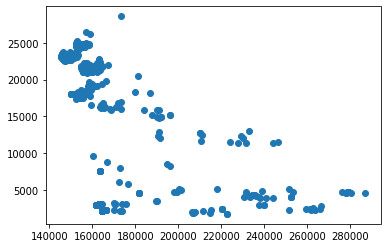

In [1482]:
# orignal 
plt.scatter(time_list, risk_list)

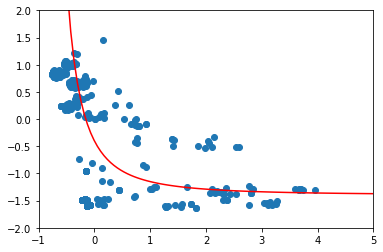

In [1483]:
plt.scatter(global_time_normalized, global_risk_normalized)

# 100 linearly spaced numbers
x = np.linspace(-0.9,5,100)
# the function, which is y = x^2 here
y = 1/(x+1)**2 -1.4
#y = 1/(x+1.2)**2 -1.6
plt.ylim([-2, 2])
plt.xlim([-1, 5])
plt.plot(x,y, 'r')
plt.show()

In [1484]:
def func(x,y):
    return 1/(x+1)**2 -1.4 -y
greenX = []
greenY = []
global_cost_list = []
greenLoop = [] # stores the loop number

blueX = []
blueY =[]
for i in range(len(global_time_normalized)):
    
    if func(global_time_normalized[i],global_risk_normalized[i]) >= 0:
    #if True:
        greenX.append(global_time_normalized[i])
        greenY.append(global_risk_normalized[i])
        global_cost_list.append((global_time_normalized[i],global_risk_normalized[i]))
        greenLoop.append(i+1)
    else:
        blueX.append(global_time_normalized[i])
        blueY.append(global_risk_normalized[i])
        

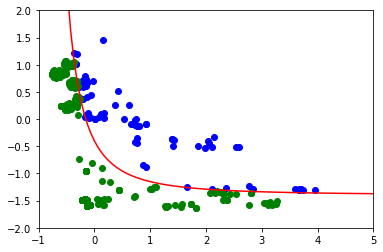

In [1485]:
plt.scatter(blueX, blueY,c ='b')
plt.scatter(greenX, greenY,c ='g')

# 100 linearly spaced numbers
x = np.linspace(-0.9,5,100)
# the function, which is y = x^2 here
y = 1/(x+1)**2 -1.4
plt.ylim([-2, 2])
plt.xlim([-1, 5])
plt.plot(x,y, 'r')
plt.show()

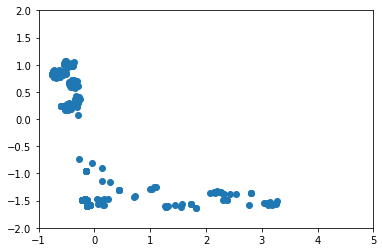

In [1486]:
#plt.scatter(blueX, blueY,c ='b')
plt.scatter(greenX, greenY)


plt.ylim([-2, 2])
plt.xlim([-1, 5])
#plt.plot(x,y, 'r')
plt.show()

In [1487]:
local_cost_list = []
time_list = []
risk_list = []

for k in local_cost:
    time_list.append(local_cost[k][0][0])
    risk_list.append(local_cost[k][0][1])
    
avgTime = np.mean(time_list)
stdTime = np.std(time_list)
avgRisk = np.mean(risk_list)
stdRisk = np.std(risk_list)
# normalized point
local_time_normalized = []
local_risk_normalized = []
for k in local_cost:
    #temp = ((global_cost[k][0][0]-avgTime)/stdTime, (global_cost[k][0][1]-avgRisk)/stdRisk)
    local_time_normalized.append((local_cost[k][0][0]-avgTime)/stdTime)
    local_risk_normalized.append((local_cost[k][0][1]-avgRisk)/stdRisk)
    local_cost_list.append(temp)

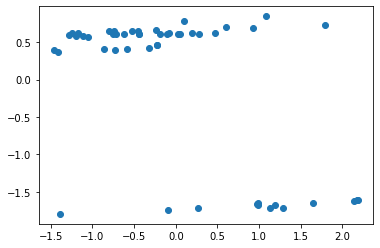

In [1488]:
plt.scatter(local_time_normalized, local_risk_normalized)
plt.show()

# Visualize with ratio data (2 factors : time and risk)

In [1489]:
global_ratio_list = []
ratio_list = []

for k in global_cost:
    ratio_list.append((global_cost[k][0][0]/global_cost[k][0][1]))
    
avgRatio = np.mean(ratio_list)
stdRatio = np.std(ratio_list)

# normalized point
global_Ratio_normalized = []
for e in ratio_list:
    global_ratio_list.append(e)
    

(array([  0.,   0.,   0.,   0.,   0.,   1., 185.,  75.,  44.,   4.,  12.,
          2.,   8.,   0.,   1.,   2.,   4.,   1.,   4.,   1.,   2.,  11.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   5.,   0.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   3.,   0.,   0.,   8.,   5.,  44.,   7.,
          2.,   2.,   2.,   2.,   3.,   6.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,  10.,
          2.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   4.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
      

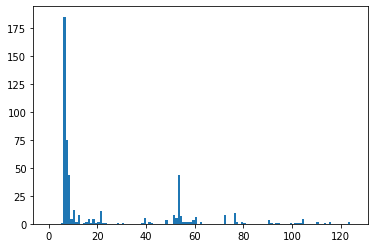

In [1490]:
bins = [0]
for i in range(125):
    bins.append(bins[-1]+1)
    
#temp = [global_ratio_list[i] for i in range(500) if kmeans.labels_[i]==0]
    
plt.hist(global_ratio_list,bins=bins)

In [1491]:
local_ratio_list = []
ratio_list = []

for k in local_cost:
    ratio_list.append((local_cost[k][0][0]/local_cost[k][0][1]))
    
avgRatio = np.mean(ratio_list)
stdRatio = np.std(ratio_list)

# normalized point
local_Ratio_normalized = []
for e in ratio_list:
    local_ratio_list.append(e)

(array([ 0.,  0.,  0.,  0.,  0., 16., 20.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  2.,  2.,  2.,  1.,  0.,  1.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

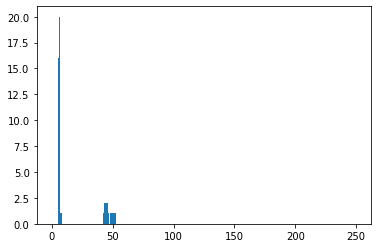

In [1492]:
bins = [0]
for i in range(250):
    bins.append(bins[-1]+1)
    
plt.hist(local_ratio_list,bins=bins)

# K means clustering based on the original features

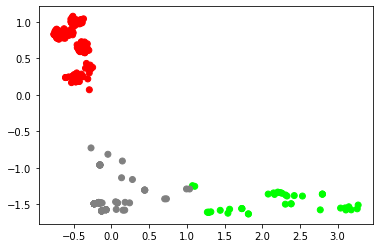

In [1493]:
kmeans = KMeans(
    init="random",
    n_clusters=clusterNumber,
    n_init=10,
    max_iter=300,
    random_state=10
)

kmeans.fit(global_cost_list)
color_labels = kmeans.labels_

# self defined colors and plot

color = [(0.5,0.5,0.5),(1,0,0),(0,1,0),(0,0,1),(0,0,0)]
color_list = []
for ind in range(len(greenX)):
    color_list.append(color[color_labels[ind]])
    
plt.scatter(greenX, greenY,c=color_list)

In [1494]:
list(color_labels).count(2)

40

# PageRank Implementation

In [1495]:
idToRoad =  []
with open("../../turning_network_linkID_updated.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
roadToIdDict ={}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
    if "intersection" not in element[0]:
        roadToIdDict[element[1].split('_')[0],element[2].split('_')[0]] = element[0]
#
#print(roadToIdDict)    

In [1496]:
# 8/3
global_trip_grouped = {}
for i in range(clusterNumber):
    global_trip_grouped[i] = []
    
for i in range(len(greenLoop)):
    key = "l" + str(greenLoop[i])
    global_trip_grouped[color_labels[i]].append(global_dict[key])


In [1497]:
def pageRank(trips, origin = '1666494', destination = '1662728'): # input a bunch of trips, return a recommendation for route
    dualArcs = {} # store the arcs for dual graph
    originalG = nx.DiGraph()
    #print(len(trips))
    for t in trips:
        subG = nx.DiGraph()
        arcList = []
        for road in t:
            startNode = idToRoadDict[str(road)][0].split('_')[0]
            endNode = idToRoadDict[str(road)][1].split('_')[0]
            arcList.append((startNode,endNode))
        subG.add_edges_from(arcList)
        
        # find the path to be added to construct dual graph
        path = nx.shortest_path(subG, origin, destination)
        
        for ind in range(len(path)-2):
            #print((path[ind],path[ind + 1]))
            originalG.add_edges_from([(path[ind],path[ind + 1])])
            current_arc = path[ind]+'_to_'+path[ind + 1]
            next_arc = path[ind + 1]+'_to_'+path[ind + 2]
            if ind == 0:
                if not (path[0] in dualArcs):
                    dualArcs[path[0]] = {current_arc : 1}
                else:
                    if not(current_arc in dualArcs[path[0]]):
                        dualArcs[path[0]][current_arc] = 1
                    else:
                        dualArcs[path[0]][current_arc] += 1
            
            if not (current_arc in dualArcs):
                dualArcs[current_arc] = {next_arc : 1}
            else:
                if not (next_arc in dualArcs[current_arc]):
                    dualArcs[current_arc][next_arc] = 1
                else:
                    dualArcs[current_arc][next_arc] += 1

        last_arc = path[-2]+'_to_'+path[-1]
        originalG.add_edges_from([(path[-2],path[-1])])
        if not (last_arc in dualArcs):
                dualArcs[last_arc] = {path[-1] : 1}
        else:
            if not (path[-1] in dualArcs[last_arc]):
                dualArcs[last_arc][path[-1]] = 1
            else:
                dualArcs[last_arc][path[-1]] += 1
                
    for key in dualArcs:
        sumCount = 0
        for key2 in dualArcs[key]:
            sumCount += dualArcs[key][key2]
            
        for key2 in dualArcs[key]:
            dualArcs[key][key2] /= sumCount
        
    dualG = nx.DiGraph()
    
    dualArcList = []
    for key in dualArcs:
        for key2 in dualArcs[key]:
            dualArcList.append((key,key2,{'weight':dualArcs[key][key2]}))
            
    dualG.add_edges_from(dualArcList)
    dualG.add_edges_from([(destination,origin,{'weight':1})])
    #record pageRank result
    result = nx.pagerank(dualG, weight='weight', alpha=0.9)
    
    weightNode = {}
    for k in result:
        if '_to_' in k:
            startNode = k.split('_to_')[0]
            endNode = k.split('_to_')[1]
            #print(startNode,endNode)
            originalG[startNode][endNode]['weight'] = np.log(1/result[k])
            weightNode[(startNode,endNode)] = np.log(1/result[k])
    def returnWeight(start,end,weight):
        
        return weight['weight']
            
    optimalPath = nx.shortest_path(originalG,source=origin,target=destination,weight=returnWeight)
    print(originalG['1666494'])
    return optimalPath
        
        
        

In [1498]:
group_optimal_path = []
for g in range(clusterNumber):
    group_optimal_path.append(pageRank(global_trip_grouped[g]))

{'1666490': {'weight': 4.827166646131085}, '1666498': {'weight': 5.421657236287303}}
{'1666490': {'weight': 5.756170126915875}, '1666498': {'weight': 4.5400560734865465}}
{'1666490': {'weight': 4.577895265496707}}


In [1499]:
def pageRank_local_info(trips, local_trips, local_value = 30,origin = '1666494', destination = '1662728'): # input a bunch of trips, return a recommendation for route
    dualArcs = {} # store the arcs for dual graph
    originalG = nx.DiGraph()
    #print(len(trips))
    for t in trips:
        subG = nx.DiGraph()
        arcList = []
        for road in t:
            startNode = idToRoadDict[str(road)][0].split('_')[0]
            endNode = idToRoadDict[str(road)][1].split('_')[0]
            arcList.append((startNode,endNode))
        subG.add_edges_from(arcList)
        
        # find the path to be added to construct dual graph
        path = nx.shortest_path(subG, origin, destination)
        #print(path)
        for ind in range(len(path)-2):
            #print((path[ind],path[ind + 1]))
            originalG.add_edges_from([(path[ind],path[ind + 1])])
            current_arc = path[ind]+'_to_'+path[ind + 1]
            next_arc = path[ind + 1]+'_to_'+path[ind + 2]
            if ind == 0:
                if not (path[0] in dualArcs):
                    dualArcs[path[0]] = {current_arc : 1}
                else:
                    if not(current_arc in dualArcs[path[0]]):
                        dualArcs[path[0]][current_arc] = 1
                    else:
                        dualArcs[path[0]][current_arc] += 1
            
            if not (current_arc in dualArcs):
                dualArcs[current_arc] = {next_arc : 1}
            else:
                if not (next_arc in dualArcs[current_arc]):
                    dualArcs[current_arc][next_arc] = 1
                else:
                    dualArcs[current_arc][next_arc] += 1

        last_arc = path[-2]+'_to_'+path[-1]
        originalG.add_edges_from([(path[-2],path[-1])])
        if not (last_arc in dualArcs):
                dualArcs[last_arc] = {path[-1] : 1}
        else:
            if not (path[-1] in dualArcs[last_arc]):
                dualArcs[last_arc][path[-1]] = 1
            else:
                dualArcs[last_arc][path[-1]] += 1
    
    # add local path information
    for t in local_trips:
        path = []
        for road in local_trips[t]:
            startNode = idToRoadDict[str(road)][0].split('_')[0]
            endNode = idToRoadDict[str(road)][1].split('_')[0]
            path.append(startNode)
        # add the last end node
        path.append(endNode)
        
        for ind in range(len(path)-2):
            #print((path[ind],path[ind + 1]))
            current_arc = path[ind]+'_to_'+path[ind + 1]
            next_arc = path[ind + 1]+'_to_'+path[ind + 2]
            
            if current_arc in dualArcs and next_arc in dualArcs[current_arc]:
                dualArcs[current_arc][next_arc] += local_value
                     
    
    for key in dualArcs:
        sumCount = 0
        for key2 in dualArcs[key]:
            sumCount += dualArcs[key][key2]
            
        for key2 in dualArcs[key]:
            dualArcs[key][key2] /= sumCount
        
    dualG = nx.DiGraph()
    
    dualArcList = []
    for key in dualArcs:
        for key2 in dualArcs[key]:
            dualArcList.append((key,key2,{'weight':dualArcs[key][key2]}))
            
    dualG.add_edges_from(dualArcList)
    dualG.add_edges_from([(destination,origin,{'weight':1})])
    #record pageRank result
    result = nx.pagerank(dualG, weight='weight', alpha=0.9)
    
    weightNode = {}
    for k in result:
        if '_to_' in k:
            startNode = k.split('_to_')[0]
            endNode = k.split('_to_')[1]
            #print(startNode,endNode)
            originalG[startNode][endNode]['weight'] = np.log(1/result[k])
            weightNode[(startNode,endNode)] = np.log(1/result[k])
    def returnWeight(start,end,weight):
        
        return weight['weight']
            
    optimalPath = nx.shortest_path(originalG,source=origin,target=destination,weight=returnWeight)
    #print(originalG['1666494'])
    return optimalPath
        
        
        

In [1500]:
updated_group_optimal_path = []
for g in range(clusterNumber):
    updated_group_optimal_path.append(pageRank_local_info(global_trip_grouped[g], local_route, local_value = 50, origin = '1666494', destination = '1662728'))

In [1501]:
updated_group_optimal_path[1] == group_optimal_path[1]

False

In [1502]:
# used to save the recommended path
# with open("group_5_optimal_path_L_filtered_2.pk", 'wb') as f:
#     pickle.dump(group_optimal_path,f)

In [1503]:
group_optimal_path[2] == updated_group_optimal_path[2]

False

In [1504]:
group_optimal_path[1]

['1666494',
 '1666498',
 '1666500',
 '1666504',
 '1666512',
 '1666025',
 '1665735',
 '1665120',
 '1664738',
 '1664487',
 '1663739',
 '1663569',
 '10698',
 '10695',
 '10691',
 '1663401',
 '1663394',
 '1663378',
 '2176343',
 '2290881',
 '2176384',
 '2290840',
 '2290837',
 '2176407',
 '15381',
 '1663319',
 '1663314',
 '1663301',
 '1663224',
 '1663218',
 '1663149',
 '1663079',
 '1663076',
 '1663078',
 '1663081',
 '1663072',
 '1663083',
 '1663090',
 '1663059',
 '1662887',
 '1662813',
 '1662751',
 '1662704',
 '1662749',
 '1662738',
 '1662728']

In [1505]:
updated_group_optimal_path[1]

['1666494',
 '1666498',
 '1666500',
 '1666504',
 '1666512',
 '1666025',
 '1665735',
 '1665120',
 '1664738',
 '1664487',
 '1663739',
 '1663569',
 '10698',
 '10695',
 '10691',
 '1663401',
 '1663394',
 '1663378',
 '2176343',
 '2290881',
 '2176384',
 '2290840',
 '2290837',
 '2176407',
 '15381',
 '1663319',
 '1663314',
 '1663301',
 '1663299',
 '1663294',
 '1663291',
 '1663292',
 '1663293',
 '1663344',
 '1663374',
 '1663361',
 '1663351',
 '1663352',
 '1663059',
 '1662887',
 '1662813',
 '1662751',
 '1662704',
 '1662749',
 '1662738',
 '1662728']

# construct the preference ratio distribution of the groups

In [1506]:
ratioDict = {}
for g in range(clusterNumber):
    ratioDict[g] = []
    
for idx in range(len(greenLoop)):
    k = 'l' + str(greenLoop[idx])
    ratioDict[kmeans.labels_[idx]].append(global_cost[k][0][0]/global_cost[k][0][1]) 
    #ratioDict[kmeans.labels_[idx]].append(global_cost[k][0][1]/global_cost[k][0][2]) 
    #ratioDict[kmeans.labels_[idx-1]].append(global_cost[k][0][1]/global_cost[k][0][0])



In [1507]:
greenLoop

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 40,
 43,
 44,
 45,
 50,
 57,
 59,
 60,
 65,
 67,
 69,
 71,
 72,
 74,
 78,
 89,
 90,
 92,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 174,
 175,
 176,
 177,
 178,
 181,
 182,
 183,
 184,
 185,
 186,
 188,
 189,
 190,
 191,
 192,
 195,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 208,
 209,
 210,
 212,
 213,
 214,
 215,
 216,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 23

In [1508]:
normalDistribution = {}

for g in range(clusterNumber):
    normalDistribution[g] =  {'mean': np.mean(ratioDict[g]) , 'std':np.std(ratioDict[g]) }

In [1509]:
normalDistribution

{0: {'mean': 52.77365691905402, 'std': 15.31306140027161},
 1: {'mean': 6.8623125864298515, 'std': 0.8070654745349164},
 2: {'mean': 82.84067423557823, 'std': 24.711794938893433}}

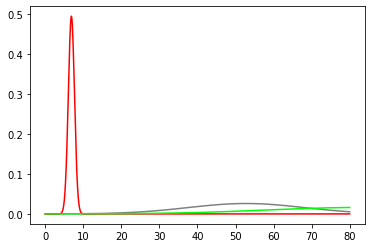

In [1510]:
x_axis = np.arange(0, 80, 0.0001)

for g in range(clusterNumber):
    #if g == 0 :
    #    continue
    plt.plot(x_axis, stats.norm.pdf(x_axis, normalDistribution[g]['mean'], normalDistribution[g]['std']),c=color[g])
plt.show()

# construct the preference ratio distribution for the user

In [1511]:
ratioLocal = []
    
for idx in range(1,51):
    k = 'l'+str(idx)
    ratioLocal.append(local_cost[k][0][0]/local_cost[k][0][1])
    #ratioLocal.append(local_cost[k][0][1]/local_cost[k][0][2])

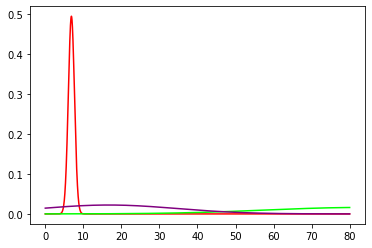

In [1512]:
x_axis = np.arange(0, 80, 0.0001)

for g in range(clusterNumber):
    if g ==0 :
        continue
    plt.plot(x_axis, stats.norm.pdf(x_axis, normalDistribution[g]['mean'], normalDistribution[g]['std']),c=color[g])

plt.plot(x_axis, stats.norm.pdf(x_axis,np.mean(ratioLocal),np.std(ratioLocal)),c='purple')
    
plt.show()

# Calculate KL-divergence

In [1513]:
def KLDivergence(mean1,std1,mean2,std2):
    
    return np.log(std2/std1) + (std1**2 + (mean1-mean2)**2)/(2*std2**2) - 1/2

In [1514]:
for g in range(clusterNumber):
    print('KL(group{},user) : {}'.format(g, KLDivergence(np.mean(ratioLocal),
                                                         np.std(ratioLocal), 
                                                         normalDistribution[g]['mean'], 
                                                         normalDistribution[g]['std'])
                                        ))
    

KL(group0,user) : 2.806362731338732
KL(group1,user) : 317.2153814076395
KL(group2,user) : 3.66835811136976


# Filter the useful trip for the user

In [1515]:
distance = []
for key in global_cost:
    distance.append(global_cost[key][0][0])

np.mean(distance)

168342.36359924925

In [1516]:
local_cost_raw_list = []
for key in local_cost:
    local_cost_raw_list.append(local_cost[key][0])
    
local_cost_raw_list.sort(key = lambda x : abs(x[0]-np.mean(distance)))
#print(local_cost_raw_list)

In [1517]:
# choose top k
local_cost_raw_list = local_cost_raw_list[:topKK]

In [1518]:
ratioLocal = []
ratioLocal2 = []
for cost in local_cost_raw_list:
    ratioLocal.append(cost[0]/cost[1])
    ratioLocal2.append([cost[0]/cost[1]])
    #ratioLocal2.append([cost[1]/cost[2]])

In [1519]:
for g in range(clusterNumber):
    print('KL(group{},user) : {}'.format(g, KLDivergence(np.mean(ratioLocal2),
                                                         np.std(ratioLocal2), 
                                                         normalDistribution[g]['mean'], 
                                                         normalDistribution[g]['std'])
                                        ))

KL(group0,user) : 2.806362731338731
KL(group1,user) : 317.21538140763954
KL(group2,user) : 3.66835811136976


# Get the pdf of user preference using gaussian mixture model

In [1520]:
userPref = GaussianMixture(n_components=1, random_state=0).fit(ratioLocal2)

# Compute the cost of the recommended path

In [1521]:
######### information for turns ##########
turn_list = []
with open("../../turning_network_linkID_updated.csv",'r') as f:
    reader = csv.reader(f)
    turn_list = list(reader)
    
isTurn = []
with open("../../turning_network_turn_updated.csv",'r') as f:
    reader = csv.reader(f)
    isTurn = list(reader)
    
isTurnDict = {}
for turn in isTurn:
    isTurnDict[(turn[0],turn[1])] = int(turn[2])
    
road_ID_with_turn = {}
for element in turn_list:
    road_ID_with_turn[element[0]] = (element[1],element[2])
    
def calculateTurn(trip):
    total_turn = 0
    for i in trip:
        total_turn += isTurnDict[road_ID_with_turn[i]]
    return total_turn
######### information for turns end ##########


######### information for calculating time ##########
time_list = []
with open("../../turning_network_time_updated.csv",'r') as f:
    time_list = csv.reader(f)
    time_list = list(time_list)

timeDict = {}
for element in time_list:
    timeDict[(element[0],element[1])] = float(element[2])-1
    
def calculateTime(trip): # trip needs to contain intersections
    total_time = 0
    for i in trip:
        total_time += timeDict[road_ID_with_turn[i]]
    return total_time
######### information for calculating time ends ##########

######### information for calculating distance ##########
distance_list = []
with open("../../link_file.csv",'r') as f:
    distance_list = csv.reader(f)
    distance_list = list(distance_list)
    
distance_dict = {}
for element in distance_list:
    distance_dict[(element[0],element[1])] = int(element[2])
    
idToRoad =  []
with open("../../road_file.csv",'r') as f:
    idToRoad = csv.reader(f)
    idToRoad = list(idToRoad)
    
idToRoadDict = {}
for element in idToRoad:
    idToRoadDict[element[0]] = (element[1],element[2])
        

def calculateDist(trip):
    total_distance = 0
    for i in trip:
        if i in idToRoadDict:
            total_distance += distance_dict[idToRoadDict[i]]
    return total_distance   
######### information for calculating distance ends##########

######### information for calculating risk ##########
risk_list = None
with open("../../crash_drisk0320.csv",'r') as f:
    risk_list = csv.reader(f)
    risk_list = list(risk_list)
    
riskDict = {}
for element in risk_list:
    riskDict[(element[0],element[1])] = float(element[2])
    
def calculateRisk(trip):
    total_risk = 0
    for i in trip:
        total_risk += riskDict[road_ID_with_turn[i]]
    return total_risk

######### information for calculating risk ends ##########


In [1522]:
import copy
another_timeDict = copy.deepcopy(timeDict)
for key in timeDict:
    k1 = key[0].split('_')[0]
    k2 = key[1].split('_')[0]
    if k1 != k2:
        another_timeDict[k1,k2] = timeDict[key]
        
another_riskDict = copy.deepcopy(riskDict)
for key in riskDict:
    k1 = key[0].split('_')[0]
    k2 = key[1].split('_')[0]
    if k1 != k2:
        another_riskDict[k1,k2] = riskDict[key]

In [1523]:
def costVector(trajDictInterSect):
    costDict = {}
    for k in trajDictInterSect:
        temp =  []
        temp.append([calculateTime(trajDictInterSect[k]),calculateRisk(trajDictInterSect[k]),
                    calculateDist(trajDictInterSect[k]),calculateTurn(trajDictInterSect[k])])
        costDict[k] = temp
    return costDict

In [1524]:
def calculateTime2(trip):
    total_time = 0
    for idx in range(len(trip)-1):
        total_time += another_timeDict[trip[idx],trip[idx + 1]]
    return total_time
def calculateRisk2(trip):
    total_risk = 0
    for idx in range(len(trip)-1):
        total_risk += another_riskDict[trip[idx],trip[idx + 1]]
    return total_risk

In [1525]:
# without prior
color_labels_list = list(color_labels)

for g in range(clusterNumber):
    ratioTemp = calculateTime2(group_optimal_path[g])*99/calculateRisk2(group_optimal_path[g])
#     print('Group{} log likelihood = {}'.format(g,
#                                               np.log(np.exp(userPref.score_samples([[ratioTemp]])[0])*(color_labels_list.count(g)/len(color_labels_list)))
#                                               )
#          )
    print('Group{} log likelihood = {}'.format(g,
                                              userPref.score_samples([[ratioTemp]])[0]
                                              )
         )

Group0 log likelihood = -5.919652390498473
Group1 log likelihood = -3.967619759506328
Group2 log likelihood = -6.261661028181379


In [1526]:
# with prior
# color_labels_list = list(color_labels)

# for g in range(clusterNumber):
#     ratioTemp = calculateTime2(group_optimal_path[g])*99/calculateRisk2(group_optimal_path[g])
#     print('Group{} log likelihood = {}'.format(g,
#                                               np.log(np.exp(userPref.score_samples([[ratioTemp]])[0])*(color_labels_list.count(g)/len(color_labels_list)))
#                                               )
#          )
#     print('Group{} log likelihood = {}'.format(g,
#                                               userPref.score_samples([[ratioTemp]])[0]
#                                               )
#          )

In [1527]:
####### prior #######
def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

local_mean = np.mean(ratioLocal2)
#normalDistribution
for g in range(clusterNumber):
    ratioTemp = calculateTime2(group_optimal_path[g])*99/calculateRisk2(group_optimal_path[g])
    print('Group{} log likelihood = {}'.format(g,
                                              normal_dist(local_mean , normalDistribution[g]['mean'] , normalDistribution[g]['std'])\
                                               *(color_labels_list.count(g)/len(color_labels_list)))
                                              )


Group0 log likelihood = 0.7252354884537772
Group1 log likelihood = 1.3176745039167857e-32
Group2 log likelihood = 0.21122795740077419


In [1528]:
normalDistribution

{0: {'mean': 52.77365691905402, 'std': 15.31306140027161},
 1: {'mean': 6.8623125864298515, 'std': 0.8070654745349164},
 2: {'mean': 82.84067423557823, 'std': 24.711794938893433}}

# Get route for qgis

In [1529]:
with open('../../reference_coordinate','rb') as f:
    coordinates = pickle.load(f)

In [1530]:
coords = []
for key in coordinates:
    coords.append((key,coordinates[key]))

In [1531]:
origin = '1666494'
destination = '1662728'

In [1532]:
def findNearest(point,k=50):
    target = coordinates[point]
    coords.sort(key= lambda x : abs(x[1][0]-target[0]) + abs(x[1][1]-target[1]))
    neighbors = []
    for i in range(k):
        neighbors.append(str(coords[i][0])+'_1')
    return neighbors

In [1533]:

for k in local_route['l50']:
    if 'intersection' not in k:
        print("\"RDWY_LINK_\" = ",k, " OR ")

"RDWY_LINK_" =  4827432  OR 
"RDWY_LINK_" =  4845225  OR 
"RDWY_LINK_" =  4848820  OR 
"RDWY_LINK_" =  4848819  OR 
"RDWY_LINK_" =  4850759  OR 
"RDWY_LINK_" =  4850758  OR 
"RDWY_LINK_" =  4844283  OR 
"RDWY_LINK_" =  4843593  OR 
"RDWY_LINK_" =  4843236  OR 
"RDWY_LINK_" =  4843002  OR 
"RDWY_LINK_" =  4842245  OR 
"RDWY_LINK_" =  5455237  OR 
"RDWY_LINK_" =  5314179  OR 
"RDWY_LINK_" =  4841931  OR 
"RDWY_LINK_" =  5314201  OR 
"RDWY_LINK_" =  5314203  OR 
"RDWY_LINK_" =  5314206  OR 
"RDWY_LINK_" =  5455239  OR 
"RDWY_LINK_" =  5488969  OR 
"RDWY_LINK_" =  5488970  OR 
"RDWY_LINK_" =  5488965  OR 
"RDWY_LINK_" =  5488966  OR 
"RDWY_LINK_" =  5488958  OR 
"RDWY_LINK_" =  5314540  OR 
"RDWY_LINK_" =  4841813  OR 
"RDWY_LINK_" =  4841812  OR 
"RDWY_LINK_" =  4841808  OR 
"RDWY_LINK_" =  4841796  OR 
"RDWY_LINK_" =  4841792  OR 
"RDWY_LINK_" =  4820402  OR 
"RDWY_LINK_" =  4820399  OR 
"RDWY_LINK_" =  4849540  OR 
"RDWY_LINK_" =  4849539  OR 
"RDWY_LINK_" =  4841705  OR 
"RDWY_LINK_" =

In [1534]:
local_route['l50']

['4827432',
 '4845225',
 '4848820',
 '4848819',
 '4850759',
 '4850758',
 '4844283',
 '4843593',
 '4843236',
 '4843002',
 '4842245',
 '5455237',
 '5314179',
 '4841931',
 '5314201',
 '5314203',
 '5314206',
 '5455239',
 '5488969',
 '5488970',
 '5488965',
 '5488966',
 '5488958',
 '5314540',
 '4841813',
 '4841812',
 '4841808',
 '4841796',
 '4841792',
 '4820402',
 '4820399',
 '4849540',
 '4849539',
 '4841705',
 '4841640',
 '4841586',
 '4841584',
 '4820189',
 '4820139',
 '4820090',
 '4820050',
 '4819977',
 '4819976',
 '4819972',
 '5064246',
 '4841262',
 '4819875',
 '4841260',
 '4841251']